In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import h5py

In [2]:
swf360_dir = "/store1/shared/sparseGFP_SWF360/data_processed_220"
swf467_dir = "/store1/shared/panneuralGFP_SWF467/data_processed_220"
# swf1212_dir = "/store1/shared/panneuralGFP_SWF1212/data_processed_220"
prj_ssn_dir = "/data1/prj_sexsharedneurons/FailedHeadReg"
demo_cam_dir = "/store1/shared/confocal_debugging/data_processed_220"

### ImageClick main version

In [3]:
labels_dir = {
    # swf360
    "2022-03-16-03": swf360_dir + "/2022-03-16-03_output/ImageClick/coordinates_20241227_230032.csv",
    "2022-03-24-02": swf360_dir + "/2022-03-24-02_output/ImageClick/coordinates_20241227_222855.csv",
    "2022-03-30-01": swf360_dir + "/2022-03-30-01_output/ImageClick/coordinates_20250111_025054.csv",
    "2022-03-30-02": swf360_dir + "/2022-03-30-02_output/ImageClick/coordinates_20250114_005049.csv",
    "2022-03-31-01": swf360_dir + "/2022-03-31-01_output/ImageClick/coordinates_20250114_001624.csv",
    
    # swf467    
    "2022-03-16-02": swf467_dir + "/2022-03-16-02_output/ImageClick/coordinates_20250105_204910.csv",

    # swf1212
    "2024-05-22-08": "/data1/prj_sexsharedneurons/FailedHeadReg/2024-05-22-08/labels.csv",

    # new_cam
    "2024-12-19-08_output": demo_cam_dir + "/2024-12-19-08_output/ImageClick/coordinates_20250107_000302.csv"
}

In [4]:
max_per_dataset = 60
all_imgs_raw = []
all_imgs_label = []

for k,path_csv in labels_dir.items():
    print(path_csv)
    
    png_dir = os.path.dirname(path_csv)
    csv = pd.read_csv(path_csv)

    for row in range(min(len(csv), max_per_dataset)):
        
        png_path = os.path.join(png_dir, csv['Image'][row]) # create full path
        img_raw = np.array(Image.open(png_path), dtype=np.uint16)
        
        # head_pos = (csv['Y'][row], csv['X'][row]) # invert xy coordinates to retrieve label as a single point
        img_label = np.zeros(img_raw.shape, dtype=bool)

        # Create meshgrid of coordinates
        y, x = np.ogrid[:img_label.shape[0], :img_label.shape[1]]
        
        # Calculate distances from head_pos
        distances = np.sqrt((x - csv['X'][row])**2 + (y - csv['Y'][row])**2)
        
        # Set values where distance < 25 to 1
        img_label[distances < 25] = 1

        all_imgs_raw.append(img_raw)
        all_imgs_label.append(img_label)

/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-16-03_output/ImageClick/coordinates_20241227_230032.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-24-02_output/ImageClick/coordinates_20241227_222855.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-01_output/ImageClick/coordinates_20250111_025054.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-30-02_output/ImageClick/coordinates_20250114_005049.csv
/store1/shared/sparseGFP_SWF360/data_processed_220/2022-03-31-01_output/ImageClick/coordinates_20250114_001624.csv
/store1/shared/panneuralGFP_SWF467/data_processed_220/2022-03-16-02_output/ImageClick/coordinates_20250105_204910.csv
/data1/prj_sexsharedneurons/FailedHeadReg/2024-05-22-08/labels.csv
/store1/shared/confocal_debugging/data_processed_220/2024-12-19-08_output/ImageClick/coordinates_20250107_000302.csv


### Gradio ImageClick

In [5]:
another_labels_dir = {
    
}

In [6]:
max_per_dataset = 60

for k,path_csv in another_labels_dir.items():
    print(path_csv)
    
    png_dir = os.path.dirname(path_csv)
    csv = pd.read_csv(path_csv)

    for row in range(min(len(csv), max_per_dataset)):
        
        png_path = os.path.join(png_dir, csv['image_name'][row]) # create full path
        img_raw = np.array(Image.open(png_path), dtype=np.uint16)
        
        # head_pos = (csv['Y'][row], csv['X'][row]) # invert xy coordinates to retrieve label as a single point
        img_label = np.zeros(img_raw.shape, dtype=bool)

        # Create meshgrid of coordinates
        y, x = np.ogrid[:img_label.shape[0], :img_label.shape[1]]
        
        # Calculate distances from head_pos
        str_coords = csv['coordinates'][row]
        if str_coords != "skipped":
            coords = str_coords.split(',')  
            xcoord = int(coords[0])           
            ycoord = int(coords[1])        
            distances = np.sqrt((x - xcoord)**2 + (y - ycoord)**2)
            
            # Set values where distance < 25 to 1
            img_label[distances < 25] = 1
    
            all_imgs_raw.append(img_raw)
            all_imgs_label.append(img_label)

### Export data as HDF5

In [7]:
path_new_h5 = "/store1/candy/prj_unet2d/data/postCropNet_2024.h5"
total = 0

# Open the HDF5 file in write mode
with h5py.File(path_new_h5, 'w') as f:
    for i in range(len(all_imgs_label)):  # Python uses 0-based indexing
        # Create group name as string
        d = str(i + 1)  # +1 to match Julia's 1-based indexing
        
        # Create a new group
        grp = f.create_group(d)
        
        # Store the image and label data in the group
        # Convert to uint16 (equivalent to UInt16 in Julia)
        grp.create_dataset("img", data=all_imgs_raw[i].astype(np.uint16))
        grp.create_dataset("label", data=all_imgs_label[i])
        total += 1
total

480

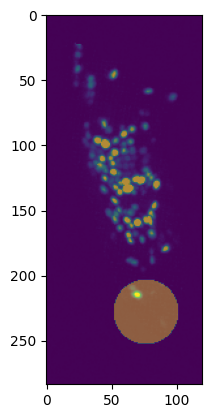

In [12]:
### check to see if output is as expected
path_h5 = "/store1/candy/prj_unet2d/data/postCropNet_2024.h5"
i = '250'

with h5py.File(path_h5, 'r') as file:
    img_raw = file[i]['img'][()]    # converts to numpy array
    img_label = file[i]['label'][()] # converts to numpy array

plt.imshow(img_raw)
plt.imshow(img_label, alpha=0.4)